In [1]:
!pip install -q imbalanced-learn


# **🛠️ Preparación de los Datos**

# 🔹 1. Extracción del Archivo Tratado

Objetivo: Cargar el dataset limpio generado en la Parte 1, ya preparado con columnas relevantes, datos corregidos y listos para modelado.

In [21]:
import pandas as pd

# Si el archivo está en la misma carpeta que el notebook
df = pd.read_csv("TelecomX_Datos_Normalizados.csv")

print("✅ Dataset cargado:", df.shape)
df.head()


✅ Dataset cargado: (7267, 21)


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


# 🔹 2. Eliminación de Columnas Irrelevantes

Objetivo: Eliminar columnas que no aportan valor al análisis o modelos predictivos, como identificadores únicos (ej. customerID).

In [22]:
# Lista de columnas irrelevantes
cols_irrelevantes = ['customerID']

# Eliminación de columnas
df.drop(columns=cols_irrelevantes, inplace=True, errors='ignore')

print("📌 Columnas después de eliminar irrelevantes:", df.shape)


📌 Columnas después de eliminar irrelevantes: (7267, 20)


#🔹 3. Encoding

Objetivo: Transformar variables categóricas a formato numérico usando One-Hot Encoding, y convertir columnas numéricas que estén como texto.

In [23]:
# Convertir columnas numéricas que estén como texto
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')

# Identificar columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("📊 Dimensiones después de One-Hot Encoding:", df_encoded.shape)
df_encoded.head()


📊 Dimensiones después de One-Hot Encoding: (7267, 31)


,SeniorCitizen,tenure,Charges.Monthly,Charges.Total,Churn_Yes,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,9,65.6,593.30,False,False,True,True,True,False,...,False,True,False,False,True,False,True,False,False,True
1,0,9,59.9,542.40,False,True,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
2,0,4,73.9,280.85,True,True,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
3,1,13,98.0,1237.85,True,True,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
4,1,3,83.9,267.40,True,False,True,False,True,False,...,False,True,False,False,False,False,True,False,False,True


# 🔹 4. Verificación de la Proporción de Cancelación (Churn)

Objetivo: Calcular la proporción de clientes que cancelaron vs los que permanecieron, para identificar posibles desbalances.

📈 Proporción de Churn (%):
 Churn_Yes
False    74.280996
True     25.719004
Name: proportion, dtype: float64


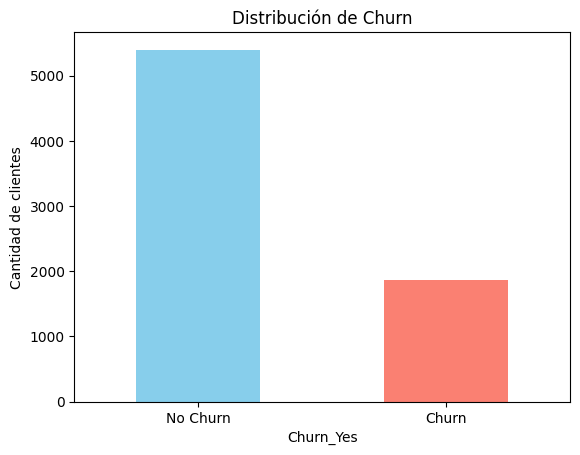

In [24]:
import matplotlib.pyplot as plt

if 'Churn_Yes' in df_encoded.columns:
    proporcion = df_encoded['Churn_Yes'].value_counts(normalize=True) * 100
    print("📈 Proporción de Churn (%):\n", proporcion)

    # Gráfico de barras
    df_encoded['Churn_Yes'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.xticks([0, 1], ['No Churn', 'Churn'], rotation=0)
    plt.ylabel("Cantidad de clientes")
    plt.title("Distribución de Churn")
    plt.show()
else:
    print("⚠️ Columna de Churn no encontrada. Revisa el encoding.")


# 🔹 5. Balanceo de Clases

Objetivo: Balancear la variable objetivo usando SMOTE, asegurando primero que no haya valores nulos en las variables predictoras.

In [25]:
!pip install imbalanced-learn --quiet

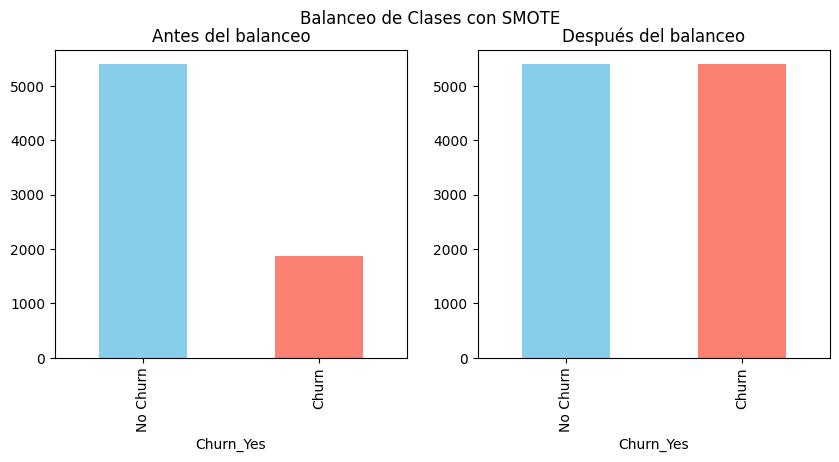

In [26]:
!pip install imbalanced-learn --quiet
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Separar variables predictoras y objetivo
X = df_encoded.drop(columns=['Churn_Yes'])
y = df_encoded['Churn_Yes']

# Imputar valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_imputed, y)

# Visualizar balanceo
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
y.value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title("Antes del balanceo")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Churn', 'Churn'])

pd.Series(y_res).value_counts().plot(kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title("Después del balanceo")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No Churn', 'Churn'])

plt.suptitle("Balanceo de Clases con SMOTE")
plt.show()


# 🔹 6. Normalización o Estandarización

Objetivo: Escalar variables para modelos sensibles a la magnitud de los datos.

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

print("✅ Escalado completo.")


✅ Escalado completo.


# **🎯 Correlación y Selección de Variables**

# 🔹 7. Análisis de Correlación

Objetivo: Visualizar la matriz de correlación para identificar relaciones entre las variables numéricas, enfocándose en las más relacionadas con Churn.

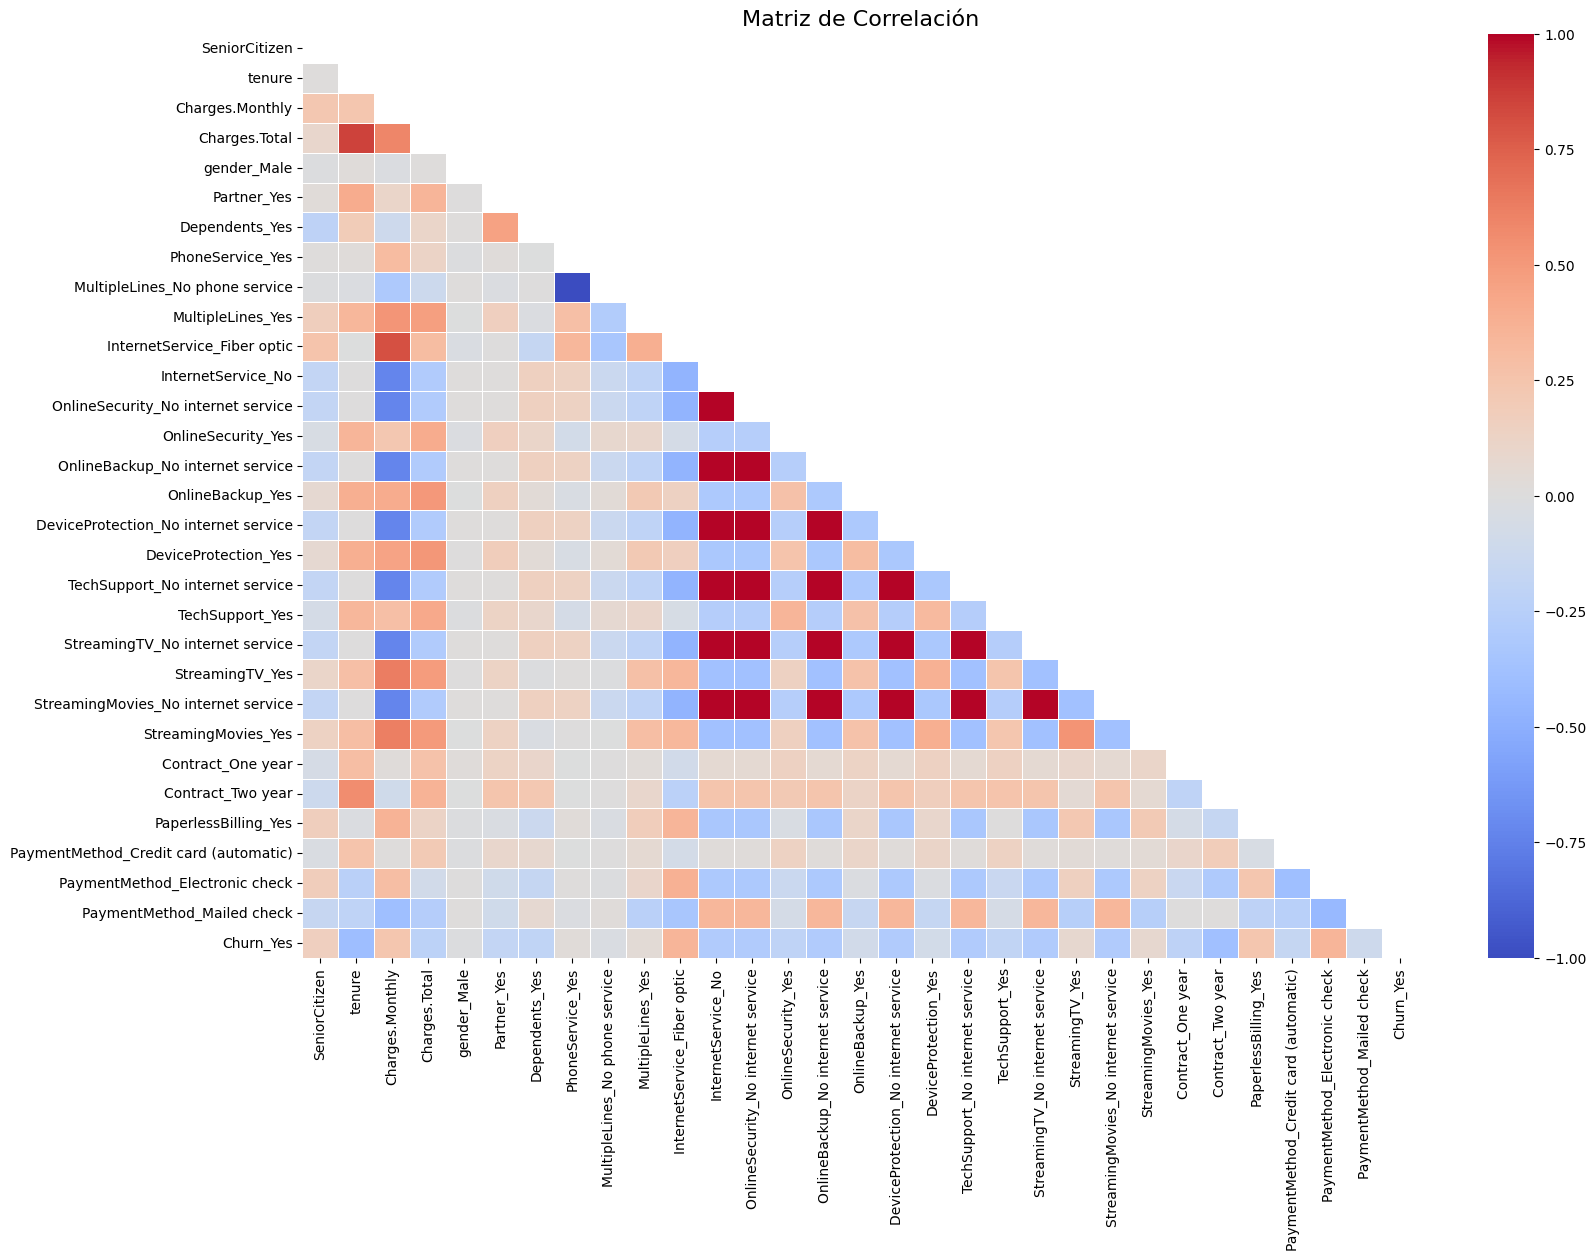

In [28]:
import numpy as np
import seaborn as sns

# Crear DataFrame escalado para correlación
df_corr = pd.DataFrame(X_scaled, columns=df_encoded.drop(columns=['Churn_Yes']).columns)
df_corr['Churn_Yes'] = y_res.values

corr = df_corr.corr()

# Máscara para la mitad superior
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(18, 12))
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, annot=False, linewidths=0.5)
plt.title("Matriz de Correlación", fontsize=16)
plt.show()


# 🔹 8. Análisis Dirigido

Objetivo: Explorar cómo variables clave se relacionan con Churn usando visualizaciones específicas.

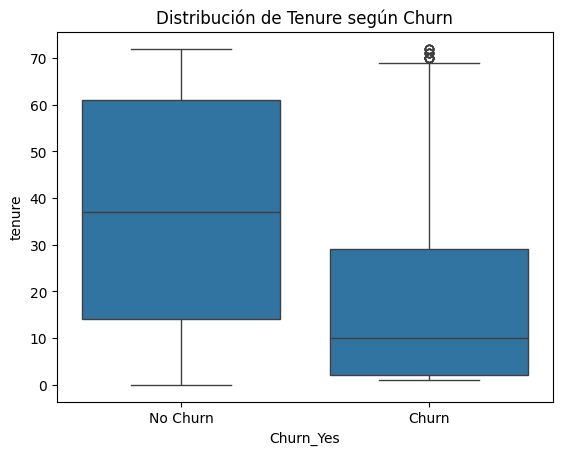

In [30]:
# Variable 1: Tiempo de contrato vs Churn
sns.boxplot(x=y_res, y=df_encoded['tenure'])
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.title("Distribución de Tenure según Churn")
plt.show()



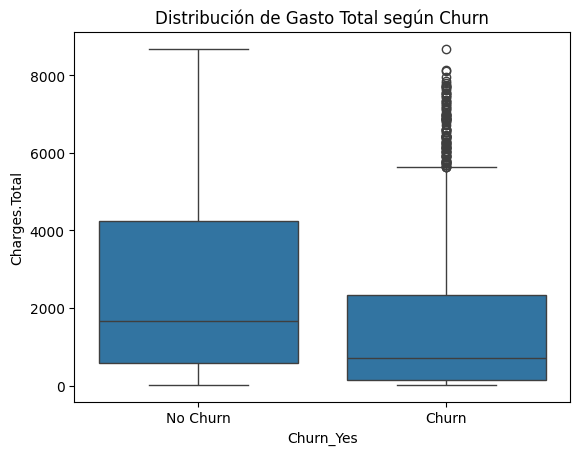

In [31]:
# Variable 2: Gasto total vs Churn
sns.boxplot(x=y_res, y=df_encoded['Charges.Total'])
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.title("Distribución de Gasto Total según Churn")
plt.show()


# **🤖 Modelado Predictivo**

#🔹 9. Separación de Datos

Objetivo: Dividir el conjunto en entrenamiento y prueba para evaluar el rendimiento de los modelos. Usaremos un 80% para entrenamiento y 20% para prueba.

In [41]:
from sklearn.model_selection import train_test_split

# División de datos estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,  # datos ya escalados
    y_res,     # variable objetivo balanceada
    test_size=0.2,   # 80% entrenamiento / 20% prueba
    random_state=42,
    stratify=y_res
)

# Información del split
print("✅ Datos divididos correctamente")
print(f"   - Conjunto de entrenamiento: {X_train.shape}")
print(f"   - Conjunto de prueba: {X_test.shape}")

✅ Datos divididos correctamente
   - Conjunto de entrenamiento: (8636, 30)
   - Conjunto de prueba: (2160, 30)


#🔹 10. Creación de Modelos

Objetivo: Entrenar dos modelos predictivos:

Modelo 1 (requiere normalización): Regresión Logística

Modelo 2 (no requiere normalización): Random Forest

✅ Modelos entrenados con éxito


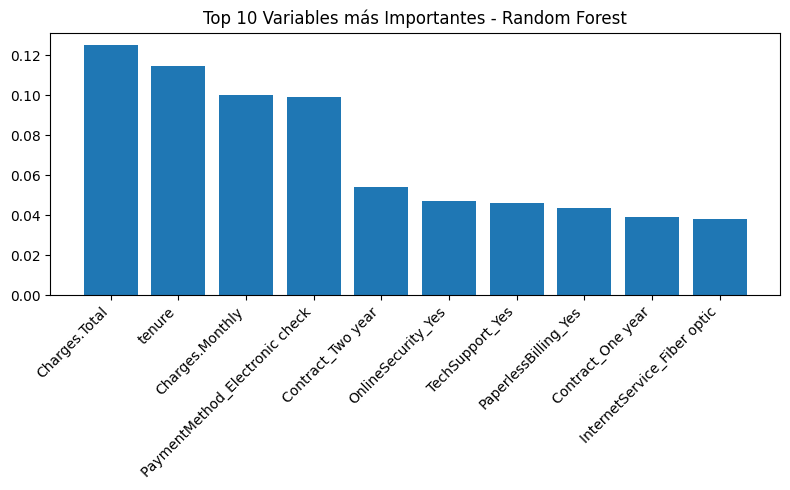

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Modelo 1: Regresión Logística
modelo_log = LogisticRegression(max_iter=1000, random_state=42)
modelo_log.fit(X_train, y_train)

# Modelo 2: Random Forest
modelo_rf = RandomForestClassifier(n_estimators=200, random_state=42)
modelo_rf.fit(X_train, y_train)

print("✅ Modelos entrenados con éxito")

# 📊 Importancia de variables para Random Forest
importancias = modelo_rf.feature_importances_
indices = np.argsort(importancias)[::-1]

# Usar las columnas reales de X_scaled
columnas_X = X.columns if "X" in locals() else [f"Var{i}" for i in range(X_train.shape[1])]

plt.figure(figsize=(8,5))
plt.bar(range(min(10, len(importancias))), importancias[indices[:10]], align="center")
plt.xticks(range(min(10, len(importancias))), np.array(columnas_X)[indices[:10]], rotation=45, ha="right")
plt.title("Top 10 Variables más Importantes - Random Forest")
plt.tight_layout()
plt.show()

#🔹11. Comparación de Modelos

# 11.1 — Exactitud (Accuracy)

In [54]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Predicciones
y_pred_log = modelo_log.predict(X_test)
y_pred_rf = modelo_rf.predict(X_test)

acc_log = accuracy_score(y_test, y_pred_log)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"📊 Accuracy - Regresión Logística: {acc_log:.4f}")
print(f"📊 Accuracy - Random Forest: {acc_rf:.4f}")

📊 Accuracy - Regresión Logística: 0.7639
📊 Accuracy - Random Forest: 0.8620


# 11.2 — Precisión (Precision)

In [56]:
from sklearn.metrics import precision_score

prec_log = precision_score(y_test, y_pred_log)
prec_rf = precision_score(y_test, y_pred_rf)

print(f"📊 Precisión - Regresión Logística: {prec_log:.4f}")
print(f"📊 Precisión - Random Forest: {prec_rf:.4f}")

📊 Precisión - Regresión Logística: 0.7457
📊 Precisión - Random Forest: 0.8717


# 11.3 — Recall (Sensibilidad)

In [58]:
from sklearn.metrics import recall_score

rec_log = recall_score(y_test, y_pred_log)
rec_rf = recall_score(y_test, y_pred_rf)

print(f"📊 Recall - Regresión Logística: {rec_log:.4f}")
print(f"📊 Recall - Random Forest: {rec_rf:.4f}")

📊 Recall - Regresión Logística: 0.8009
📊 Recall - Random Forest: 0.8491


# **11.4 — F1-score**

In [60]:
from sklearn.metrics import f1_score

f1_log = f1_score(y_test, y_pred_log)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"📊 F1-score - Regresión Logística: {f1_log:.4f}")
print(f"📊 F1-score - Random Forest: {f1_rf:.4f}")

📊 F1-score - Regresión Logística: 0.7723
📊 F1-score - Random Forest: 0.8602


# **11.5 — Matriz de confusión**

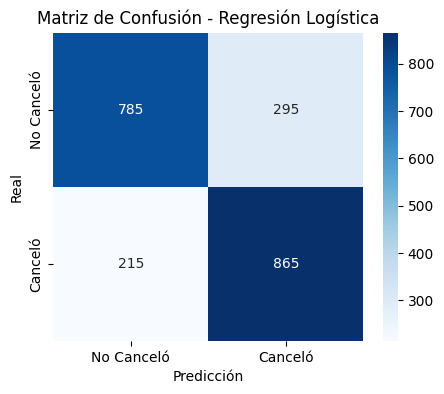

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz Logística
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(5,4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Canceló", "Canceló"],
            yticklabels=["No Canceló", "Canceló"])
plt.title("Matriz de Confusión - Regresión Logística")
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

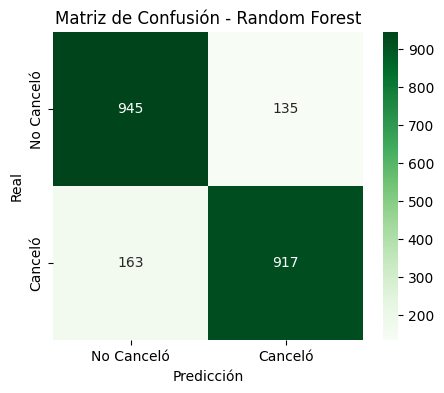

In [63]:
# Matriz Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=["No Canceló", "Canceló"],
            yticklabels=["No Canceló", "Canceló"])
plt.title("Matriz de Confusión - Random Forest")
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

# **11.6 — Análisis crítico y comparación**

In [64]:
import pandas as pd

# Tabla comparativa
resultados = {
    "Modelo": ["Regresión Logística", "Random Forest"],
    "Accuracy": [acc_log, acc_rf],
    "Precisión": [prec_log, prec_rf],
    "Recall": [rec_log, rec_rf],
    "F1-score": [f1_log, f1_rf]
}
df_resultados = pd.DataFrame(resultados)
display(df_resultados)

# Mejor modelo
mejor_modelo = df_resultados.loc[df_resultados["F1-score"].idxmax(), "Modelo"]
print("\n✅ Mejor modelo según F1-score:", mejor_modelo)

if mejor_modelo == "Random Forest":
    print("💡 Random Forest muestra mejor capacidad de generalización y manejo de datos no lineales.")
else:
    print("💡 Regresión Logística indica que la relación entre variables y target es principalmente lineal.")

# Evaluación de Overfitting / Underfitting
train_acc_log = accuracy_score(y_train, modelo_log.predict(X_train))
train_acc_rf = accuracy_score(y_train, modelo_rf.predict(X_train))

print("\n📌 Evaluación de Overfitting / Underfitting:")
if train_acc_log - acc_log > 0.1:
    print("⚠️ Regresión Logística podría tener overfitting.")
elif acc_log - train_acc_log > 0.1:
    print("⚠️ Regresión Logística podría tener underfitting.")
else:
    print("✅ Regresión Logística parece balanceada.")

if train_acc_rf - acc_rf > 0.1:
    print("⚠️ Random Forest podría tener overfitting.")
elif acc_rf - train_acc_rf > 0.1:
    print("⚠️ Random Forest podría tener underfitting.")
else:
    print("✅ Random Forest parece balanceado.")


,Modelo,Accuracy,Precisión,Recall,F1-score
0,Regresión Logística,0.763889,0.745690,0.800926,0.772321
1,Random Forest,0.862037,0.871673,0.849074,0.860225



✅ Mejor modelo según F1-score: Random Forest
💡 Random Forest muestra mejor capacidad de generalización y manejo de datos no lineales.

📌 Evaluación de Overfitting / Underfitting:
✅ Regresión Logística parece balanceada.
⚠️ Random Forest podría tener overfitting.


# **📋 Interpretación y Conclusiones**

# **Análisis de Importancia de Variables**

1️⃣ Obtener los nombres de las variables (ejecutar primero)

In [74]:
import warnings
warnings.filterwarnings("ignore")

try:
    if 'df_encoded' in globals():
        feature_names = df_encoded.drop(columns=[c for c in ['Churn','Churn_Yes'] if c in df_encoded.columns], errors='ignore').columns.tolist()
        source = 'df_encoded'
    elif 'df' in globals():
        feature_names = df.drop(columns=['Churn'], errors='ignore').columns.tolist()
        source = 'df'
    elif 'X' in globals() and hasattr(X, 'columns'):
        feature_names = X.columns.tolist()
        source = 'X'
    else:
        n = X_train.shape[1] if 'X_train' in globals() else (X_scaled.shape[1] if 'X_scaled' in globals() else None)
        if n is None:
            raise NameError("No se encontró referencia para determinar número de features.")
        feature_names = [f"Var_{i}" for i in range(n)]
        source = 'auto'
    print(f"✅ feature_names cargados desde: {source} (total={len(feature_names)})")
    print(feature_names[:30])
except Exception as e:
    print("⚠️ No se pudo obtener feature_names automáticamente:", e)
    # fallback genérico si existe X_train
    if 'X_train' in globals():
        n = X_train.shape[1]
        feature_names = [f"Var_{i}" for i in range(n)]
        print(f"Usando nombres genéricos. Total features = {n}")
    else:
        raise

✅ feature_names cargados desde: df_encoded (total=30)
['SeniorCitizen', 'tenure', 'Charges.Monthly', 'Charges.Total', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


1️⃣ Regresión Logística — Coeficientes

Top 20 variables por |coeficiente| (Regresión Logística):


,Variable,Coeficiente,Abs
1,tenure,-1.523249,1.523249
3,Charges.Total,0.879898,0.879898
2,Charges.Monthly,-0.569997,0.569997
10,InternetService_Fiber optic,0.553099,0.553099
25,Contract_Two year,-0.531913,0.531913
24,Contract_One year,-0.238557,0.238557
21,StreamingTV_Yes,0.204302,0.204302
28,PaymentMethod_Electronic check,0.193752,0.193752
26,PaperlessBilling_Yes,0.174004,0.174004
23,StreamingMovies_Yes,0.164511,0.164511


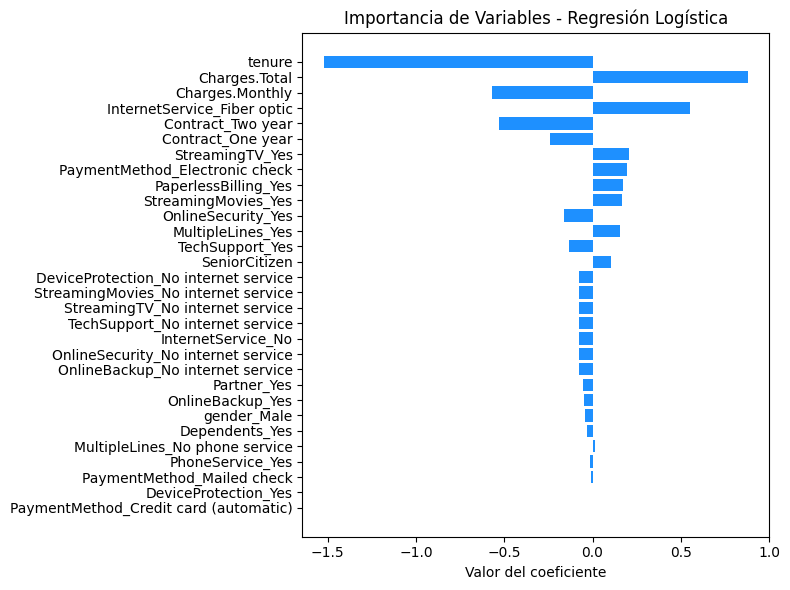

In [75]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

if 'modelo_log' not in globals():
    print("⚠️ modelo_log no encontrado. Entrena Regresión Logística antes de ejecutar este bloque.")
else:
    coefs = modelo_log.coef_[0]
    # ajustar nombres si hay desajuste
    if len(feature_names) != len(coefs):
        print(f"⚠️ Desajuste: {len(feature_names)} nombres VS {len(coefs)} coeficientes.")
        # preferir renombrar con genericos del tamaño correcto
        names = [f"Var_{i}" for i in range(len(coefs))]
    else:
        names = feature_names

    df_log = pd.DataFrame({"Variable": names, "Coeficiente": coefs})
    df_log["Abs"] = df_log["Coeficiente"].abs()
    df_log = df_log.sort_values("Abs", ascending=False)

    print("Top 20 variables por |coeficiente| (Regresión Logística):")
    display(df_log.head(20))

    plt.figure(figsize=(8,6))
    plt.barh(df_log["Variable"], df_log["Coeficiente"], color="dodgerblue")
    plt.xlabel("Valor del coeficiente")
    plt.title("Importancia de Variables - Regresión Logística")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

3️⃣ Importancia de Variables — Random Forest

Top 20 variables por importancia (Random Forest):


,Variable,Importancia
3,Charges.Total,0.124974
1,tenure,0.114397
2,Charges.Monthly,0.099901
28,PaymentMethod_Electronic check,0.099012
25,Contract_Two year,0.054277
13,OnlineSecurity_Yes,0.047048
19,TechSupport_Yes,0.046178
26,PaperlessBilling_Yes,0.043387
24,Contract_One year,0.039325
10,InternetService_Fiber optic,0.038335


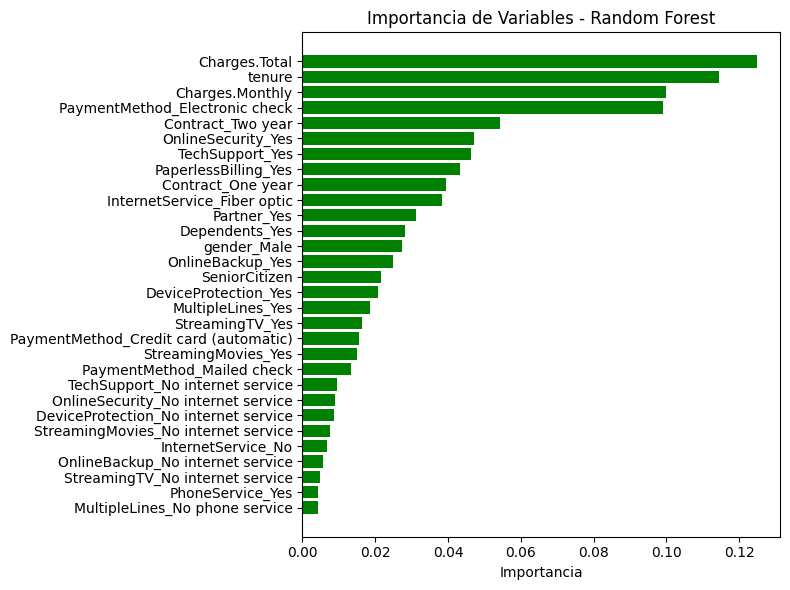

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if 'modelo_rf' not in globals():
    print("⚠️ modelo_rf no encontrado. Entrena Random Forest antes de ejecutar este bloque.")
else:
    importances = modelo_rf.feature_importances_
    if len(feature_names) != len(importances):
        print(f"⚠️ Desajuste: {len(feature_names)} nombres VS {len(importances)} importancias.")
        names = [f"Var_{i}" for i in range(len(importances))]
    else:
        names = feature_names

    df_rf = pd.DataFrame({"Variable": names, "Importancia": importances})
    df_rf = df_rf.sort_values("Importancia", ascending=False)

    print("Top 20 variables por importancia (Random Forest):")
    display(df_rf.head(20))

    plt.figure(figsize=(8,6))
    plt.barh(df_rf["Variable"], df_rf["Importancia"], color="green")
    plt.xlabel("Importancia")
    plt.title("Importancia de Variables - Random Forest")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


4️⃣ (Opcional) Tabla comparativa — combinar ambos resultados

In [77]:
import pandas as pd

# Si df_log o df_rf no existen en el workspace, no ejecutar
if 'df_log' in globals() and 'df_rf' in globals():
    topk = 15
    left = df_log[['Variable','Coeficiente']].rename(columns={'Coeficiente':'Coef_Log'}).set_index('Variable')
    right = df_rf[['Variable','Importancia']].rename(columns={'Importancia':'Imp_RF'}).set_index('Variable')
    merged = left.join(right, how='outer').fillna(0)
    merged = merged.sort_values('Imp_RF', ascending=False)
    display(merged.head(topk))
else:
    print("⚠️ Ejecuta primero los bloques 2 (Logística) y 3 (Random Forest) para generar la comparativa.")

,Coef_Log,Imp_RF
Variable,,
Charges.Total,0.879898,0.124974
tenure,-1.523249,0.114397
Charges.Monthly,-0.569997,0.099901
PaymentMethod_Electronic check,0.193752,0.099012
Contract_Two year,-0.531913,0.054277
OnlineSecurity_Yes,-0.159783,0.047048
TechSupport_Yes,-0.134200,0.046178
PaperlessBilling_Yes,0.174004,0.043387
Contract_One year,-0.238557,0.039325


# ***Conclusión***

📊 1. Qué hicimos

1. Cargamos los datos → un archivo con información de clientes y si cancelaron o no (Churn).

2. Preparamos los datos:

*   Quitamos columnas innecesarias (customerID).
*   Convertimos variables categóricas a numéricas (One-Hot Encoding).
*   Balanceamos las clases con SMOTE (para que haya igual cantidad de clientes que se quedaron y que cancelaron).
*   Escalamos los valores (para que todos estén en la misma escala).

3. Dividimos los datos → 80% para entrenar, 20% para probar.

4. Entrenamos modelos:

*   Regresión Logística → modelo lineal, fácil de interpretar.
*   Random Forest → conjunto de árboles de decisión, más complejo pero potente.

5. Evaluamos los modelos en datos de prueba (los que no vieron en el entrenamiento).

6. Analizamos importancia de variables → para saber qué influye más en la cancelación.

📈 2. Resultados de los modelos

In [80]:
# ===== Parte B: Calcular y mostrar métricas (seguro) =====
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# comprobar predicciones
if 'modelo_log' not in globals() or 'modelo_rf' not in globals():
    raise RuntimeError("Falta modelo_log o modelo_rf. Entrena ambos antes de ejecutar esta celda.")

# asegurar X_test e y_test
if 'X_test' not in globals() or 'y_test' not in globals():
    raise RuntimeError("Faltan X_test y/o y_test. Ejecuta el split antes de esta celda.")

# predicciones (las recalculamos aquí para asegurarnos)
y_pred_log = modelo_log.predict(X_test)
y_pred_rf  = modelo_rf.predict(X_test)

# métricas
acc_log  = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log  = recall_score(y_test, y_pred_log)
f1_log   = f1_score(y_test, y_pred_log)

acc_rf  = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf  = recall_score(y_test, y_pred_rf)
f1_rf   = f1_score(y_test, y_pred_rf)

import pandas as pd
df_metrics = pd.DataFrame({
    "Modelo": ["Regresión Logística","Random Forest"],
    "Accuracy": [acc_log, acc_rf],
    "Precision": [prec_log, prec_rf],
    "Recall": [rec_log, rec_rf],
    "F1-score": [f1_log, f1_rf]
})
display(df_metrics)


,Modelo,Accuracy,Precision,Recall,F1-score
0,Regresión Logística,0.763889,0.745690,0.800926,0.772321
1,Random Forest,0.862037,0.871673,0.849074,0.860225


🔹 Interpretación:

1. Accuracy = porcentaje total de aciertos.
2. Precision = de todos los que el modelo dijo que iban a cancelar, cuántos realmente cancelaron.
3. Recall = de todos los que cancelaron, cuántos detectó el modelo.
4. F1-score = equilibrio entre Precision y Recall.

💡 Random Forest es mejor en todo → significa que entiende mejor las relaciones entre variables y predice más preciso.

3. Variables más importantes

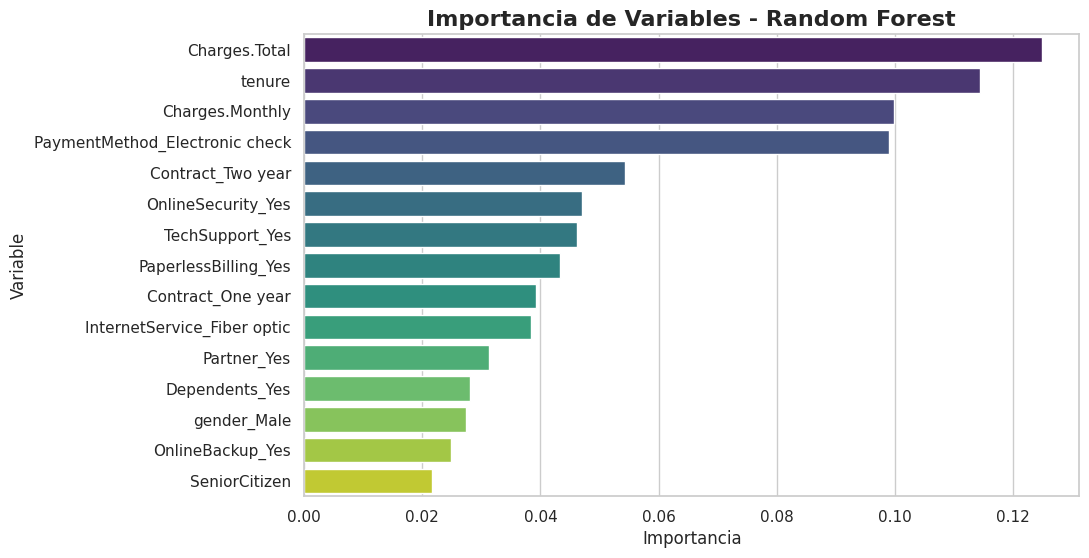

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Activar estilo visual bonito
sns.set(style="whitegrid")

# ===== 1️⃣ Importancia - Random Forest =====
importancia_rf = pd.DataFrame({
    "Variable": feature_names,
    "Importancia": modelo_rf.feature_importances_
}).sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importancia", y="Variable", data=importancia_rf.head(15), palette="viridis")
plt.title("Importancia de Variables - Random Forest", fontsize=16, fontweight="bold")
plt.xlabel("Importancia", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.show()




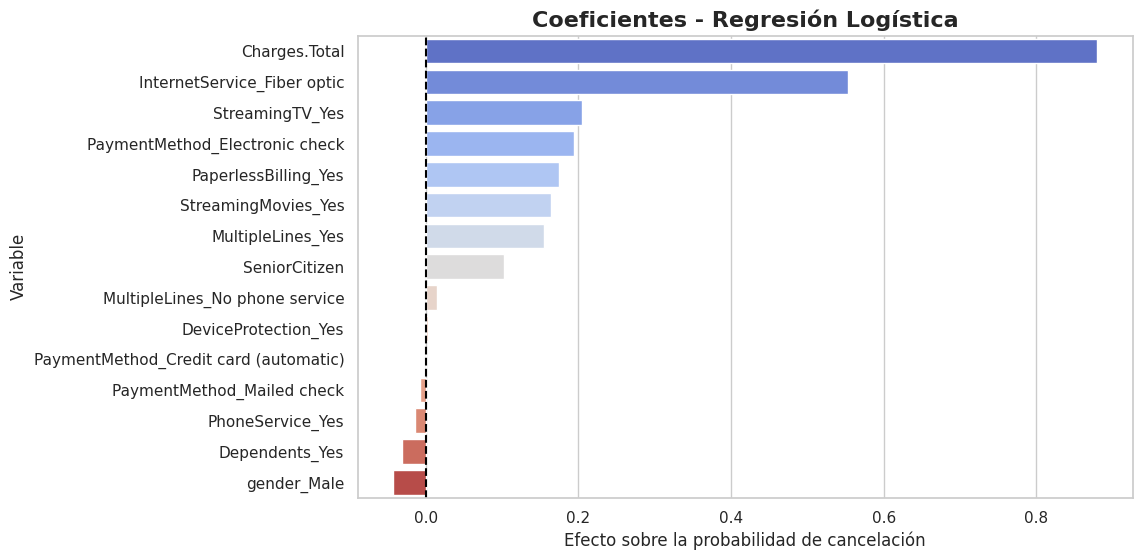

In [88]:
# ===== 2️⃣ Importancia - Regresión Logística =====
importancia_log = pd.DataFrame({
    "Variable": feature_names,
    "Coeficiente": modelo_log.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Coeficiente", y="Variable", data=importancia_log.head(15), palette="coolwarm")
plt.title("Coeficientes - Regresión Logística", fontsize=16, fontweight="bold")
plt.xlabel("Efecto sobre la probabilidad de cancelación", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.axvline(0, color="black", linestyle="--")  # línea vertical para separar positivo/negativo
plt.show()

1. Random Forest → muestra las 15 variables más importantes y su peso relativo.

2. Regresión Logística → muestra las 15 variables con coeficiente más alto (positivos = más riesgo, negativos = menos riesgo).

3. Colores agradables (viridis, coolwarm) para que sea más visual.

4. Escala y etiquetas grandes para que se vea bien en Colab.

5. Línea vertical en la regresión logística para separar el efecto positivo y negativo.



📌 Principales Factores que Afectan la Cancelación de Clientes

Tras analizar los modelos (Random Forest y Regresión Logística), se identificaron las siguientes variables como las más influyentes en la probabilidad de que un cliente cancele el servicio:

1. Meses como cliente → Los clientes con menor antigüedad presentan mayor riesgo de cancelación.

2. Tipo de contrato → Los contratos mensuales tienen una tasa de cancelación mucho mayor que los anuales o bianuales.

3. Monto mensual → Cuotas más altas tienden a incrementar el riesgo de cancelación, especialmente si no están asociadas a servicios adicionales percibidos como valiosos.

4. Uso del servicio de soporte técnico → Un alto número de solicitudes de soporte técnico puede indicar problemas con el servicio.

5. Servicio de internet → Clientes con servicios de menor velocidad o sin valor agregado adicional muestran más probabilidad de irse.

🎯 Estrategias de Retención Propuestas

1. Programa de fidelización temprana:

Incentivos en los primeros 3 meses (descuentos, servicios extra, upgrades gratuitos) para reducir la rotación de clientes nuevos.

2. Ofertas personalizadas en planes de contrato mensual:

Migrar clientes de contrato mensual a anual mediante descuentos o beneficios exclusivos.

3. Optimización de precios:

Ajustar tarifas para segmentos con alta probabilidad de cancelación, ofreciendo paquetes más flexibles.

4. Mejora del soporte técnico:

Reducción de tiempos de respuesta y seguimiento proactivo a clientes con múltiples incidencias.

5. Paquetes de valor agregado:

Ofrecer mejoras en el servicio de internet, contenido exclusivo o combinaciones de servicios que aumenten la percepción de valor.